In [3]:
from pathlib import Path
import os
compe='nlp-getting-started'
iskaggle= os.environ.get('KAGGLE_KERNEL_RUNTYPE','')
if iskaggle:
    path=Path(f'../input/{compe}')
    ! pip install -Uqq fastai
else:
    import kaggle,zipfile
    path=Path(f'{compe}')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [4]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [37]:
df=pd.read_csv(f'{compe}/train.csv')
df_test=pd.read_csv(f'{compe}/test.csv')
df_sub=pd.read_csv(f'{compe}/sample_submission.csv')

In [38]:
print('shape of train',df.shape)
print('shape of test',df_test.shape)

shape of train (7613, 5)
shape of test (3263, 4)


In [8]:
print('-----Empty array check------')
df.isna().sum()*100/df.shape[0]
# print('-'*10)

-----Empty array check------


id          0.00
keyword     0.80
location   33.27
text        0.00
target      0.00
dtype: float64

In [9]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### EDA

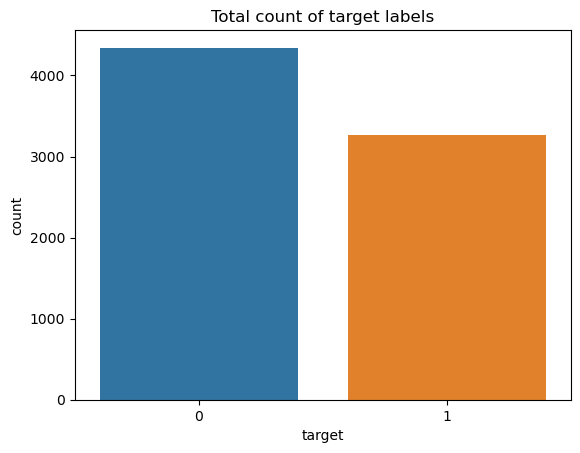

In [10]:
import seaborn as sns
sns.countplot(data=df,x='target')
plt.title('Total count of target labels')
plt.show()

In [11]:
count=df.location.value_counts()
count[count>1]


USA                         104
New York                     71
United States                50
London                       45
Canada                       29
                           ... 
New York                      2
Location                      2
In the potters hands          2
Scotland, United Kingdom      2
Hackney, London               2
Name: location, Length: 523, dtype: int64

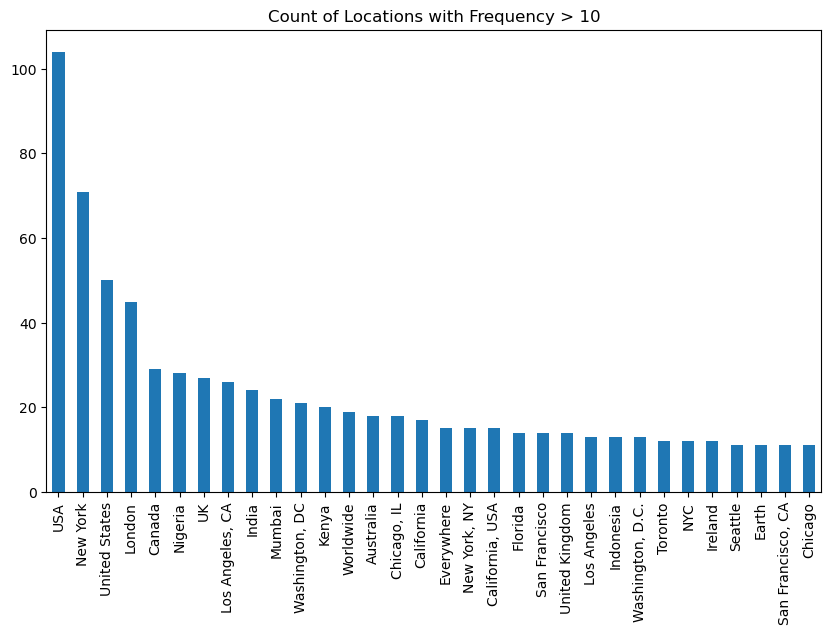

In [12]:
import matplotlib.pyplot as plt
count = df['location'].value_counts()
count_filtered = count[count > 10]

plt.figure(figsize=(10, 6))
count_filtered.plot(kind='bar')
plt.title('Count of Locations with Frequency > 10')
plt.show()

In [13]:
eda_train=df.copy()

In [14]:
tw0=eda_train[eda_train['target']==0]['text'].str.len()
tw1=eda_train[eda_train['target']==1]['text'].str.len()
tw1

0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 3271, dtype: int64

Text(0.5, 1.0, 'Normal tweets')

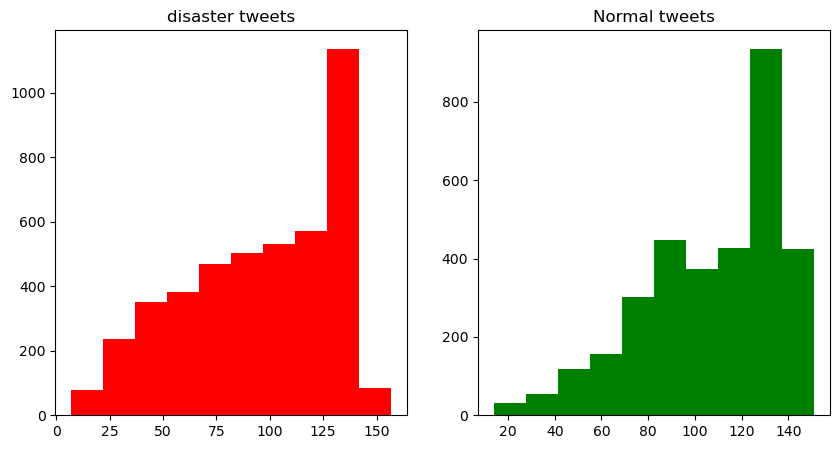

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(tw0,color='red')
ax1.set_title('disaster tweets')
ax2.hist(tw1,color='green')
ax2.set_title('Normal tweets')

* Almost Same can't differntiate using length

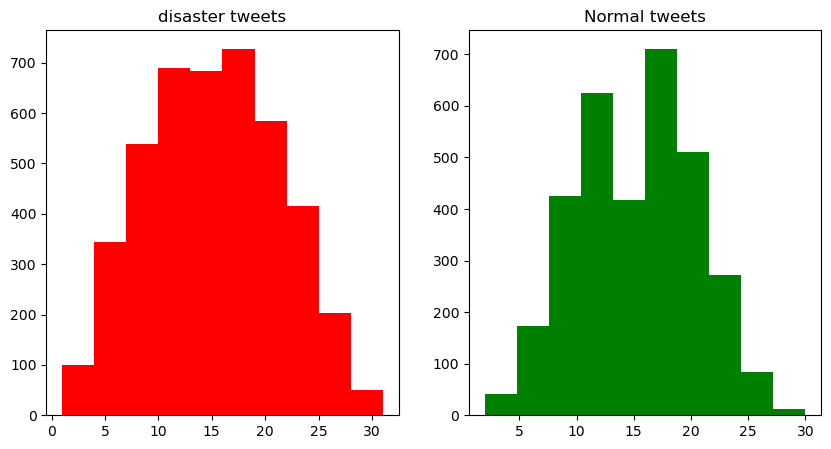

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(eda_train[eda_train['target']==0]['text'].str.split().map(lambda x:len(x)),color='red')
ax1.set_title('disaster tweets')
ax2.hist(eda_train[eda_train['target']==1]['text'].str.split().map(lambda x:len(x)),color='green')
ax2.set_title('Normal tweets')
plt.show()

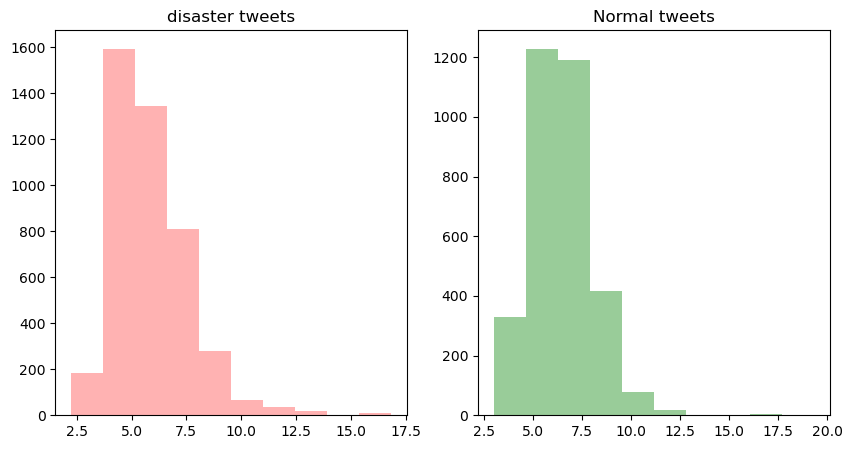

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word0=eda_train[eda_train['target']==0]['text'].str.split().apply(lambda x:[len(i) for i in x])
ax1.hist(word0.map(lambda x:np.mean(x)),color='red',alpha=0.3)
ax1.set_title('disaster tweets')
word1=eda_train[eda_train['target']==1]['text'].str.split().apply(lambda x:[len(i) for i in x])
ax2.hist(word1.map(lambda x:np.mean(x)),color='green',alpha=0.4)
ax2.set_title('Normal tweets')
plt.show()

In [18]:
def create_corpus(target):
    corpus=[]
    
    for x in eda_train[eda_train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [19]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from nltk.tokenize import word_tokenize

In [20]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

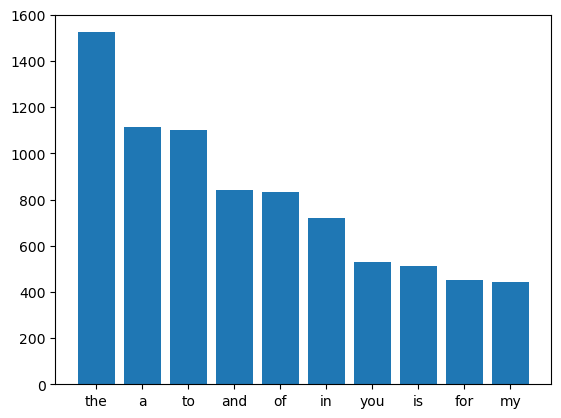

In [21]:
x,y=zip(*top)
plt.bar(x,y)

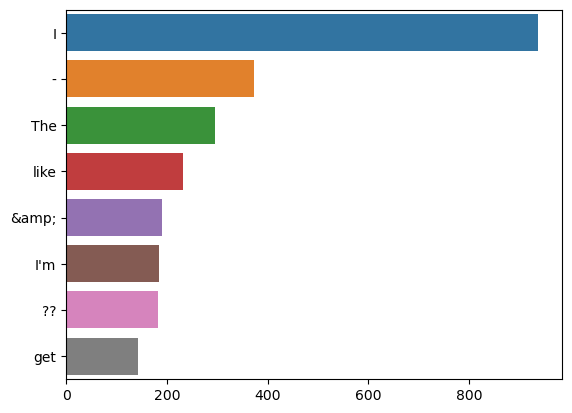

In [22]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.show()

In [23]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

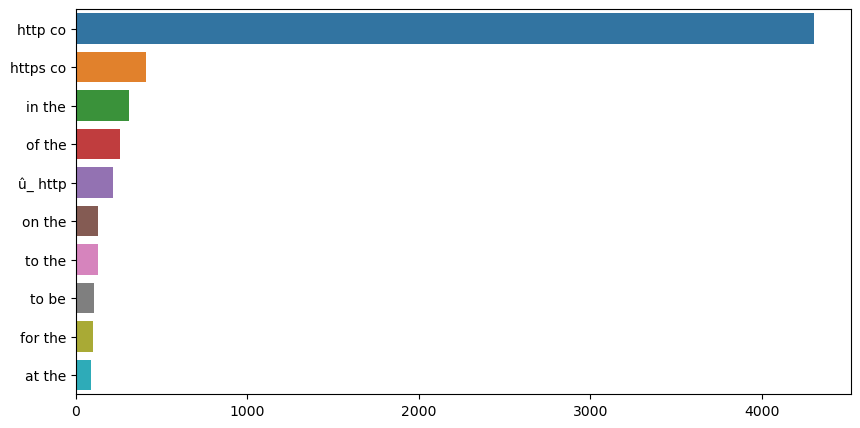

In [24]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(eda_train['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [25]:
df=pd.concat([df,df_test])
df.shape

(10876, 5)

In [26]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [27]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [49]:
df_test['text']=df_test['text'].apply(lambda x: remove_URL(x))

In [28]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [29]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [30]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [31]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [32]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

'correct me plese'

In [ ]:
# df['text']=df['text'].apply(lambda x : correct_spellings(x))

In [33]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [50]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [51]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df["text"])

In [52]:
test_vectors=count_vectorizer.transform(df_test['text'])

In [53]:
clf = linear_model.RidgeClassifier()

In [54]:
scores = model_selection.cross_val_score(clf, train_vectors, df["target"], cv=3, scoring="f1")
scores

array([0.59421842, 0.56498283, 0.64082434])

In [55]:
clf.fit(train_vectors, df["target"])

RidgeClassifier()

In [56]:
y_pred=clf.predict(test_vectors)

In [57]:
y_pred

array([0, 1, 1, ..., 1, 1, 0])

In [58]:
make_sub(y_pred,name='count_vec2')

100%|██████████| 22.2k/22.2k [00:00<00:00, 25.8kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweetssuccesully saved - count_vec2


***
<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌 Loading the dataset
</div>

***

### Submission

In [47]:
import subprocess
def make_sub(pred_y,sub_data=df_test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['id']=df_test['id']
    df_submission['target']=pred_y
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')

In [24]:
make_sub(np.zeros(df_test.shape[0]).astype(int),name='dummy_intial')

100%|██████████| 22.2k/22.2k [00:01<00:00, 18.7kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweetssuccesully saved - dummy_intial
